In [1]:
import subprocess as sb
from datetime import datetime
import signal
import os
import re

import numpy as np
import inotify.adapters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import clear_output

#TODO: Proper error handling! Current implementation doesn't do well with simulation crashes
#TODO: Add logging
#TODO: Save runs to a file!
#TODO: Pretty reports, but that's wayy into the future

In [2]:
i = inotify.adapters.Inotify()

#wait until the logfile is modified, returns time of the modification
def wait_logfile(benchmarkDir, logfile, benchmarkProcess):
    i.add_watch(benchmarkDir)
    #timeout helps in some edge cases
    while(True):
        for event in i.event_gen(yield_nones=False, timeout_s=20):
            (_, type_names, path, filename) = event

            if((filename == logfile) and 'IN_MODIFY' in type_names):
                t = os.path.getmtime(filename)
                yield t
            if(benchmarkProcess.poll() is not None):
                yield None
                return

#given an np array of unix timestamps and simulation times, returns performance in ns/day
def get_performance(simTimes, realTimes):
    dt = np.diff(realTimes)
    dv = np.diff(simTimes)
    assert(len(simTimes) == len(realTimes))
    perfs = []
    for pair in zip(dv,dt):
        perfs.append(pair[0] * 3600 * 24 / (pair[1] * 1000))
    return perfs

    



In [3]:
#class returning all the possible simulation configurations
class SimulationSource:
    def __init__(self, path_to_gromacs:str, always_needed_arguments:str):
        self.path_to_gromacs = path_to_gromacs
        self.always_needed_arguments = always_needed_arguments
        self.options = {
        "-nb": ["cpu", "gpu"], 
        "-pme": ["cpu", "gpu"], 
        "-pmefft": ["cpu", "gpu"], 
        "-bonded": ["cpu", "gpu"], 
        "-update": ["cpu", "gpu"] 
        }

    def get_all_options(self):
        #root of every command
        acc = [self.path_to_gromacs + " mdrun " + self.always_needed_arguments]
        
        for arg in self.options:
            acc2 = []
            for command in acc:
                for option in self.options[arg]:
                    acc2.append(command + " " + arg + " " + option)
            acc = acc2
        return acc
    
    def __iter__(self):
        self.iterlist = self.get_all_options()
        return self
    
    def __next__(self):
        if(self.iterlist == []):
            raise StopIteration
        else:
            return self.iterlist.pop()

for idx,x in enumerate(SimulationSource(path_to_gromacs="/usr/local/gromacs/bin/gmx_mpi",
                                always_needed_arguments="-v -deffnm step7_1")):
    print(f"{idx}: {x}")


0: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft gpu -bonded gpu -update gpu
1: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft gpu -bonded gpu -update cpu
2: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft gpu -bonded cpu -update gpu
3: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft gpu -bonded cpu -update cpu
4: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft cpu -bonded gpu -update gpu
5: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft cpu -bonded gpu -update cpu
6: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft cpu -bonded cpu -update gpu
7: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme gpu -pmefft cpu -bonded cpu -update cpu
8: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb gpu -pme cpu -pmefft gpu -bonded gpu -upd

In [4]:
#defines when a simulation will stop
def should_stop(simTimes, realTimes):
    perfs = get_performance(simTimes, realTimes)
    changeInPerf = np.diff(perfs)
    return (abs(changeInPerf[-1]) < perfs[-1] * 0.03)

In [5]:
def plot_simulation(simTimes, realTimes):
    fig, ax = plt.subplots()
    dates = [datetime.fromtimestamp(x - realTimes[0]) for x in realTimes]
    ax.plot(dates[:-1], get_performance(simTimes, realTimes))
    
    # Set locator to ensure fewer than 10 x-ticks
    locator = mdates.AutoDateLocator(maxticks=10)
    formatter = mdates.DateFormatter("%H:%M:%S")  # Format as hours, minutes, seconds, could these go for days?

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.title("Current simulation performance")
    plt.xlabel("Time")
    plt.ylabel("Performance in ns/day")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_all_simulations(indexes, timestoConverge, perfs):
    fig, ax = plt.subplots()

    for idx,x,y in zip(indexes, timestoConverge, perfs):
        ax.scatter(x, y, label=idx)

    ax.legend()

    plt.title("All simulations performance")
    plt.xlabel("Time to converge in s")
    plt.ylabel("Performance in ns/day")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

run number: 31
current configuration: /usr/local/gromacs/bin/gmx_mpi mdrun -v -deffnm step7_1 -nb cpu -pme cpu -pmefft cpu -bonded cpu -update cpu
measured in-simulation time: 4.0 ps at time: 2025-02-12 17:22:45.203038


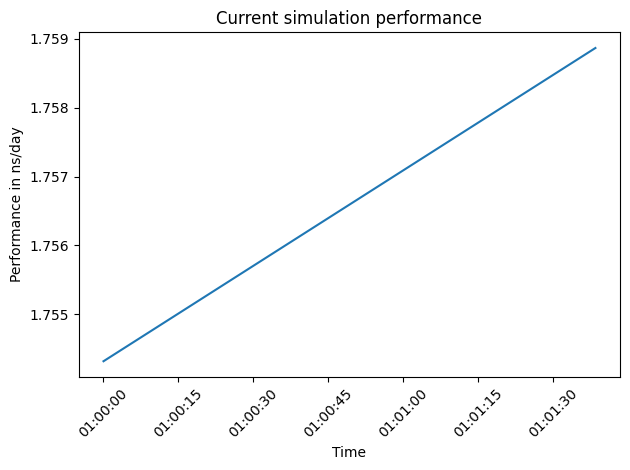



Received the INT signal, stopping within 200 steps

step 2100, will finish Thu Feb 13 00:10:34 2025

simulation exited with return code: 1


step 2150, will finish Thu Feb 13 00:10:11 2025
               Core t (s)   Wall t (s)        (%)
       Time:     2544.348      212.029     1200.0
                 (ns/day)    (hour/ns)
Performance:        1.753       13.691

GROMACS reminds you: "Never mind, death professor, your structure's fine" (TV on the Radio)



In [6]:
benchmarkDir = '.'
logfile = "step7_1.log"

indexes = []
timestoConverge = []
perfs = []

simTimesArr = []
realTimesArr = []

sims_run = 0
for command in SimulationSource(path_to_gromacs="/usr/local/gromacs/bin/gmx_mpi",
                                always_needed_arguments="-v -deffnm step7_1"):
    #we don't want to read the previous logfile by accident
    if(os.path.isfile(benchmarkDir + "/" + logfile)):
        os.rename(benchmarkDir + "/" + logfile,  benchmarkDir + "/" + "previous_" + logfile)
    #starts the simulation using command line
    proc = sb.Popen([command], shell=True)
    #spinning until process creates a logfile
    while(not os.path.isfile(benchmarkDir + "/" + logfile)):
        if(proc.poll() is not None):
            break

    inc = False
    simTimes = []
    realTimes = []
    #numbers of steps read from the logfile
    steps_recorded = 0
    clear_output(wait=True)
    for time_modified in wait_logfile(benchmarkDir, logfile, proc):
        if time_modified is None:
             break
        print("logfile modified!")
        #find all steps saved in the logfile
        stepStr = re.findall(r'Step \s+ Time\n (.*)', open(logfile).read())
        #check if the logfile was actually appended
        if(len(stepStr) > steps_recorded):
            steps_recorded = len(stepStr)
            new_simulation_time = float([x.split()[1] for x in stepStr][-1])
            simTimes.append(new_simulation_time)
            realTimes.append(time_modified)
            clear_output(wait=True)
            print(f"run number: {sims_run}")
            print(f"current configuration: {command}")
            print(f"measured in-simulation time: {new_simulation_time} ps at time: {datetime.fromtimestamp(time_modified)}")
            if(len(realTimes) > 2):
                plot_simulation(simTimes, realTimes)
                #cancel the simulation once it settled into steady state
                if(should_stop(simTimes, realTimes)):
                    break
            if(len(indexes) > 0):
                plot_all_simulations(indexes, timestoConverge, perfs)


    #ensure simulation is always finished before commiting to the next one
    proc.send_signal(signal.SIGINT)
    return_code = proc.wait()
    print(f"simulation exited with return code: {return_code}")
    if(len(simTimes) > 1):
        indexes.append(sims_run)
        timestoConverge.append(realTimes[-1] - realTimes[0])
        perfs.append(get_performance(simTimes,realTimes)[-1])
        simTimesArr.append(simTimes)
        realTimesArr.append(realTimes)


    sims_run += 1
            



In [7]:
print(simTimesArr)

[[0.0, 2.0, 4.0, 6.0], [0.0, 2.0, 4.0, 6.0], [0.0, 2.0, 4.0, 6.0], [0.0, 2.0, 4.0, 6.0], [0.0, 2.0, 4.0, 6.0, 8.0], [0.0, 2.0, 4.0, 6.0, 8.0, 10.0], [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0], [0.0, 2.0, 4.0, 6.0], [0.0, 2.0, 4.0, 6.0, 8.0], [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0], [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0], [0.0, 2.0, 4.0], [0.0, 2.0, 4.0]]


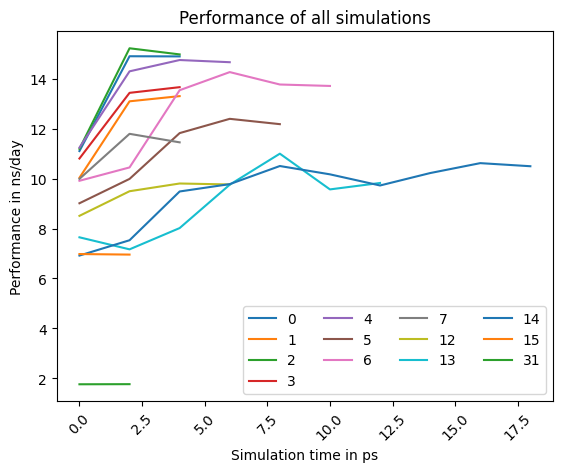

In [25]:
def plot_simulations(indexes, simTimesArr, realTimesArr):
    fig, ax = plt.subplots()
    for idx,simTimes,realTimes in zip(indexes, simTimesArr, realTimesArr):
        dates = [datetime.fromtimestamp(x - realTimes[0]) for x in realTimes]
        ax.plot(simTimes[:-1], get_performance(simTimes, realTimes), label=idx)
            
    plt.title("Performance of all simulations")
    plt.xlabel("Simulation time in ps")
    plt.ylabel("Performance in ns/day")
    plt.xticks(rotation=45)
    ax.legend(ncol=4)
    plt.show()

plot_simulations(indexes,simTimesArr, realTimesArr)